## 피마 인디언 당뇨병 예측

- 피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트를 이용해  
- 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고  
- 지금까지 학습한 오차 행렬, 정확도, 정밀도, 재현율, F1 스코어, AUC 평가 지표 적용

### 피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트
- 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- 보통 당뇨 원인으로 식습관과 유전을 꼽음
- 피마 지역은 고립된 지역에서 인디언 고유의 혈동이 지속되어 왔음
    - 그러나 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생
    - 고립된 유전적 특성 때문에 당뇨학회에서는 피마 인디언의 당뇨병 자료에 대해 많은 연구 수행

https://www.kaggle.com/  
회원가입하고 데이터 다운로드  
https://www.kaggle.com/uciml/pima-indians-diabetes-database 데이터 다운로드  
diabetes.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('./data/diabetes.csv')
diabetes_data.head()
diabetes_data.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [3]:
diabetes_data['Outcome'].value_counts()
# 마지막 칼럼 Outcome : 레이블 값
# 전체 768개 데이터 중에서
# 0 Negative 값이 500개
# 1 Positive 값이 268개
# Negative가 상대적으로 더 많음
# 당뇨병을 분류하는 문제이므로 찾아야되는 값이 1(당뇨병)
# 재현율이 중요한 문제로 보임

0    500
1    268
Name: Outcome, dtype: int64

In [4]:
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

피마 인디언 당뇨병 데이터 세트 피처
* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0또는 1)

In [5]:
diabetes_data.info()
# 결측치가 없음
# 범주형 데이터는 없음
# 피처 인코딩은 필요 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


로지스틱 회귀를 이용해 예측 모델 생성
- 데이터 세트를 피처 데이터 세트와 클래스 데이터 세트로 나누고
- 학습 데이터 세트와 테스트 데이터 세트로 분리
- 로지스틱 회귀를 이용해 예측 수행
- 성능 평가 지표 출력
- 재현율 곡선 시각화

**앞 예제에서 사용된 get_clf_eval()과 precision_recall_curve_plot() 재 로딩**

In [6]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [7]:
# 재현율 곡선 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# y_test : 실제 값  pred_proba_c1: 예측 확률 값
def precision_recall_curve_plot(y_test , pred_proba_c1): 
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0] # (143,)에서 143 추출
    # thresholds : 143이고, precisions과 recalls는 144개로 x, y축 값의 개수가 맞지 않으므로
    # precisions, recalls로 그래프 그리면 오류 
    # y 값을 [0:threshold_boundary] ([0:143])로 143개 출해서 x축 개수와 맞춤
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    # xlim() : X축 범위를 지정하거나 반환
    start, end = plt.xlim() # X축 범위 반환
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [8]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# 타겟값이 불균형함 : 타겟값의 비율에 맞춰 분할 해야 함(stratify)
X_train,X_test, y_train,y_test = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y)

**Logistic Regression으로 학습 및 예측 수행**

In [10]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred,pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8789


C:\Users\a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 의료 데이터 이므로 재현율이 중요한 데이터 임
    - 재현율이 정밀도에 비해 상대적으로 너무 낮음
    - 재현율에 촛점을 맞춰 조정

#### 참고.train_test_split()의 stratify=y 옵션  
지정한 데이터 비율 유지
전체 데이터 세트에서 레이블값 비율을  
학습 데이터 세트와 테스트 데이터 세트에서 그대로 유지

피마 인디언 당뇨병 데이터 세트
- 전체 768개 중에서 1이 268개 : 34.89 %
- stratify=y로 설정한 경우 (비율 거의 유사)
    - 학습 데이터 세트 에서 1의 비율 : 34.85 %
    - 데스트 데이터 세트에서 1의 비율 : 35.06%
- stratify=y로 설정하지 않은 경우 (비율 차이가 있음)
    - 학습 데이터 세트 에서 1의 비율 : 34.36 %
    - 데스트 데이터 세트에서 1의 비율 : 37.01 %

## 재현율 성능에 조금 더 초점을 맞춰 조정

먼저, 정밀도와 재현율 곡선을 확인하고  
임계값별로 정밀도와 재현율 값의 변화 확인

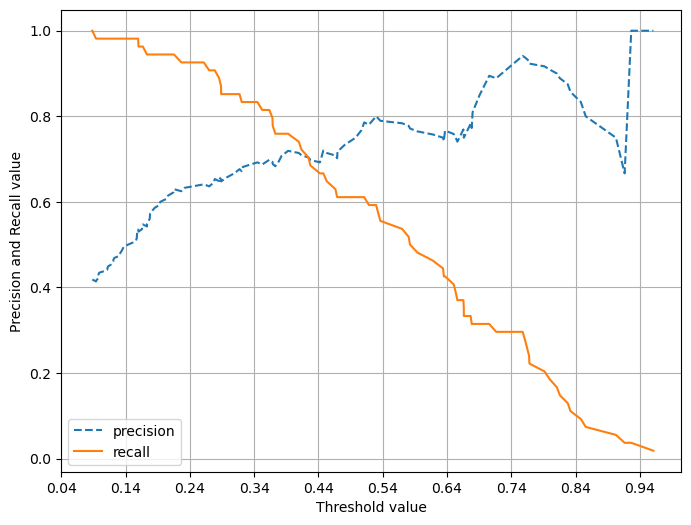

In [11]:
precision_recall_curve_plot(y_test,pred_proba )

- 정밀도와 재현율의 트레이드off가 0.42정도에서 발생하는 걸로 보임
    - 정밀도와 재현율은 0.7근처에서 값을 생성하고 있음
    - 임곗값 0.42 정도에서 균형은 이루어짐
        - 정밀도와 재현율이 0.7이 안되는 낮은 수치를 형성할 수 있기 때문에 임곗값 조정전에 데이터 값을 점검

**각 피처들의 값 분포 확인**

In [12]:
diabetes_data.describe()
# 기본 통계값을 확인 했을 때 최솟값이 0이 나오는 컬럼이 많음
# 컬럼의 특성상 0이 나오면 안되는 컬럼들에 0이 보이므로 결측을 의심해야 함

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

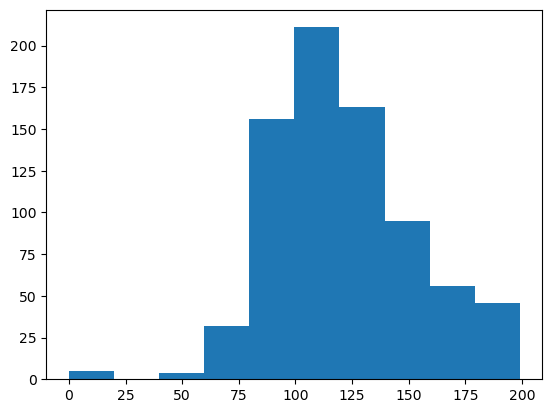

In [13]:
# Glucose(포도당) 피처 히스토그램
plt.hist(diabetes_data['Glucose'],bins=10)
# 0값이 일정수준 존재

In [14]:
# 인덱싱에 사용하려고 컬럼명 출력
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**0값이 있는 피처들에서 0값의 데이터 건수와 퍼센트 계산**
- 0 값의 데이터 건수
- 전체 데이터 건수 대비 몇 퍼센트의 비율인지 확인

In [25]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']
# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count() #768개
total_count

768

In [20]:
diabetes_data[diabetes_data['Glucose']==0]['Glucose'].count()

5

In [26]:
# 피처별로 반복하면서 값이 0인 데이터 건수 추출, 비율 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print(feature,'0 건수 : ',zero_count,' 퍼센트는 ', (100*zero_count/total_count))
    

Glucose 0 건수 :  5  퍼센트는  0.6510416666666666
BloodPressure 0 건수 :  35  퍼센트는  4.557291666666667
SkinThickness 0 건수 :  227  퍼센트는  29.557291666666668
Insulin 0 건수 :  374  퍼센트는  48.697916666666664
BMI 0 건수 :  11  퍼센트는  1.4322916666666667


- 0이 있는 레코드를 삭제할 겨우 데이터가 학습하기해 충분해 보이지 않으므로
    - 0값을 평균값으로 대체

**0값을 평균값으로 대체**

In [31]:
# diabetes_data[zero_features].replace(0,diabetes_data[zero_features].mean())

In [27]:
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0,diabetes_data[zero_features].mean()) 

In [32]:
# 피처별로 반복하면서 값이 0인 데이터 건수 추출, 비율 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print(feature,'0 건수 : ',zero_count,' 퍼센트는 ', (100*zero_count/total_count))

Glucose 0 건수 :  0  퍼센트는  0.0
BloodPressure 0 건수 :  0  퍼센트는  0.0
SkinThickness 0 건수 :  0  퍼센트는  0.0
Insulin 0 건수 :  0  퍼센트는  0.0
BMI 0 건수 :  0  퍼센트는  0.0


In [33]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


**StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용하고   
0값을 평균값으로 대체한 데이터 세트로 학습/예측**

StandardScaler : 표준화 지원 클래스
- 개별 피처를 가우시안 정규분포를 가질 수 있도록
- 평균이 0이고, 분산이 1인 값으로 변환

In [54]:
# 원본 데이터가 변경 되었으므로 재 분할
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# 정규화(표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 모든 레코드의 독립변수에 대해서 정규화를 진행
# 기준이 전체 데이터이므로 권장하지 않음

# 타겟값이 불균형함 : 타겟값의 비율에 맞춰 분할 해야 함(stratify)
X_train,X_test, y_train,y_test = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y)

In [ ]:
# 정규화(표준화)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# 모든 레코드의 독립변수에 대해서 정규화를 진행
# 기준이 전체 데이터이므로 권장하지 않음

In [49]:
# # 정규화(표준화) - 학습데이터가 기준이 되어야 함
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_sc = scaler.transform(X_train)

In [50]:
# X_test_sc = scaler.transform(X_test)

In [52]:
# # 로지스틱 회귀로 학습/예측/평가 수행
# lr_clf = LogisticRegression()
# lr_clf.fit(X_train_sc, y_train)
# pred = lr_clf.predict(X_test_sc)
# pred_proba = lr_clf.predict_proba(X_test)[:,1]

C:\Users\a\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [55]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

C:\Users\a\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [25 29]]
정확도: 0.7727, 정밀도: 0.7436, 재현율: 0.5370,    F1: 0.6237, AUC:0.8835


- **분류결정 임계값을 변화시키면서 재현율 성능 측정**
    - 재현율을 높이기 위해서는 임곗값이 낮아져야 함
    - 임계값을 0.3에서 0.5까지 0.03씩 변화시키면서
    - 재현율과 다른 평가 지표의 값 변화 확인

In [44]:
from sklearn.preprocessing import Binarizer

# 임계값에 따른 평가 수치 출력 함수
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임곗값:',custom_threshold)
        # roc_auc_score 관련 수정
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [45]:
th = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.5]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)
get_eval_by_threshold(y_test,pred_proba,th)


임곗값: 0.3
오차 행렬
[[76 24]
 [ 9 45]]
정확도: 0.7857, 정밀도: 0.6522, 재현율: 0.8333,    F1: 0.7317, AUC:0.8835

임곗값: 0.33
오차 행렬
[[79 21]
 [11 43]]
정확도: 0.7922, 정밀도: 0.6719, 재현율: 0.7963,    F1: 0.7288, AUC:0.8835

임곗값: 0.36
오차 행렬
[[81 19]
 [17 37]]
정확도: 0.7662, 정밀도: 0.6607, 재현율: 0.6852,    F1: 0.6727, AUC:0.8835

임곗값: 0.39
오차 행렬
[[84 16]
 [19 35]]
정확도: 0.7727, 정밀도: 0.6863, 재현율: 0.6481,    F1: 0.6667, AUC:0.8835

임곗값: 0.42
오차 행렬
[[85 15]
 [21 33]]
정확도: 0.7662, 정밀도: 0.6875, 재현율: 0.6111,    F1: 0.6471, AUC:0.8835

임곗값: 0.45
오차 행렬
[[89 11]
 [23 31]]
정확도: 0.7792, 정밀도: 0.7381, 재현율: 0.5741,    F1: 0.6458, AUC:0.8835

임곗값: 0.48
오차 행렬
[[90 10]
 [24 30]]
정확도: 0.7792, 정밀도: 0.7500, 재현율: 0.5556,    F1: 0.6383, AUC:0.8835

임곗값: 0.5
오차 행렬
[[90 10]
 [25 29]]
정확도: 0.7727, 정밀도: 0.7436, 재현율: 0.5370,    F1: 0.6237, AUC:0.8835


- 정밀도를 희생해서 재현율을 강화시켰음
    - 임곗값은 정밀도 0.6대긴하지만 재현율과 차이가 가장 적은 0.33을 선택

In [ ]:
평가 정리

이진 분류에서 정밀도, 재현율, F1 스코어 AUC 스코어가 주로 성능 평가 지표로 활용

특히 이진 분류의 레이블 값이 불균형하게 분포될 경우  
(0이 매우 많고, 1이 매우 적을 경우 또는 반대의 경우)  
단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도만으로는  
머신러닝 모델의 예측 성능을 평가할 수 없음

오차 행렬은 실제 클래스 값과 예측 클래스 값의 True, False에 따라   
TN, FP, FN, TP로 맵핑되는 4분면 행렬을 기반으로 예측 성능을 평가
정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP 값을 다양하게 결합해서 만들어지며
이를 통해 분류 모델 예측 성능의 오류가 어떠한 모습으로 발생하는지 알 수 있음

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 지표이며
분류 결정 임계값을 조정해서 정밀도 또는 재현율의 수치를 높이거나 낮출 수 있음


F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 좋은 값을 가짐

ROC-AUC는 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표 
AUC 스코어는 ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치